# Ch12 逆概率加权和边际结构模型

IP Weighting and Marginal Structural Models 

本书第二部分围绕因果问题“戒烟对体重增加的平均因果效应是什么？”进行组织。在本章中，我们描述如何使用IP加权从观测数据中估计这种效应。尽管在第二章中介绍了IP加权，但我们仅将其描述为非参数方法。We now describe the use of models together with IP weighting，在额外的假设下，这些模型将使我们能够处理高维问题 with many covariates and nondichotomous treatments.

为了估计戒烟对体重增加的影响，我们将使用NHEFS的真实数据，该缩写词代表国家卫生和营养检查调查数据I流行病学随访研究。NHEFS是由国家卫生统计中心和国家老龄研究所与美国公共卫生局其他机构共同发起的。
可以在 www.cdc.gov/nchs/nhanes/nhefs/ 上找到NHEFS的详细说明以及可公开获得的数据集和文档。
在本章及以后的章节中，我们将使用NHEFS数据的一部分，该数据可从本书的网站上获得。

> 我们关注的是戒烟是否会引起体重增加？

**Setup and imports**

In [2]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from collections import OrderedDict
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats
import matplotlib.pyplot as plt

In [5]:
# Just a look at a couple basic details of the dataset
nhefs_all = pd.read_excel('NHEFS.xls')
nhefs_all.shape

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


(1629, 64)

In [6]:
codebook = pd.read_excel('codebook.xls')
codebook.Description = codebook.Description.apply(lambda s: s.lower())
var_list = codebook.iloc[:, 1].tolist()
codebook.head(), var_list[:5]

(    Variable name                                        Description
 0          active  in your usual day, how active are you? in 1971...
 1             age                                        age in 1971
 2     alcoholfreq  how often do you drink?  in 1971  0: almost ev...
 3  alcoholhowmuch    when you drink, how much do you drink?  in 1971
 4       alcoholpy  have you had 1 drink past year? in 1971,  1:ev...,
 ['in your usual day, how active are you? in 1971, 0:very active, 1:moderately active, 2:inactive',
  'age in 1971',
  'how often do you drink?  in 1971  0: almost every day, 1: 2-3 times/week, 2: 1-4 times/month, 3: < 12 times/year, 4: no alcohol last year, 5: unknown',
  'when you drink, how much do you drink?  in 1971',
  'have you had 1 drink past year? in 1971,  1:ever, 0:never; 2:missing'])

## The causal question

> 戒烟是否会引起体重增加？
$\theta = E[Y^{a=1}] - E[Y^{a=0}]$如何估计呢？

Our goal is to estimate the average causal effect of smoking cessation (the treatment) A on weight gain (the outcome) Y .

In [7]:
d = nhefs_all[['qsmk', 'wt82_71']]
d.head()

qsmk    wt82_71
0     0 -10.093960
1     0   2.604970
2     0   9.414486
3     0   4.990117
4     0   4.989251

### Program 12.1

"We restricted the analysis to NHEFS individuals with known sex, age, race, ..." (pg 149, margin)

In [ ]:
restriction_cols = [
    'sex', 'age', 'race', 'wt82', 'ht', 'school', 'alcoholpy', 'smokeintensity'
]
missing = nhefs_all[restriction_cols].isnull().any(axis=1)
nhefs = nhefs_all.loc[~missing]
nhefs.shape

(1566, 64)

We're going to add some columns to help calculate Table 12.1, and a `constant` column, which will be useful for modeling

In [ ]:
nhefs['constant'] = 1
nhefs['university'] = (nhefs.education == 5).astype('int')
nhefs['inactive'] = (nhefs.active == 2).astype('int')
nhefs['no_exercise'] = (nhefs.exercise == 2).astype('int')

戒烟者和非戒烟者的平均体重增加：

In [ ]:
ave_gain_quit = nhefs[nhefs.qsmk == 1].wt82_71.mean()
ave_gain_noquit = nhefs[nhefs.qsmk == 0].wt82_71.mean()

print("Average weight gain")
print("      quitters: {:>0.1f} kg".format(ave_gain_quit))
print("  non-quitters: {:>0.1f} kg".format(ave_gain_noquit))

Average weight gain
      quitters: 4.5 kg
  non-quitters: 2.0 kg


创建一个简单的线性模型以获取体重差异的置信区间。

In [ ]:
ols = sm.OLS(nhefs.wt82_71, nhefs[['constant', 'qsmk']])
res = ols.fit()
res.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

In [ ]:
est = res.params.qsmk
conf_ints = res.conf_int(alpha=0.05, cols=None)
lo, hi = conf_ints[0]['qsmk'], conf_ints[1]['qsmk']

print('            estimate   95% C.I.')
print('difference   {:>6.2f}   ({:>0.1f}, {:>0.1f})'.format(est, lo, hi))

            estimate   95% C.I.
difference     2.54   (1.7, 3.4)


Create Table 12.1 in the margin of pg 149.

As shown in Table 12.1, quitters and non-quitters also differed in their distribution of other variables such as sex, race, education, baseline weight, and intensity of smoking. If these variables are confounders, then they also need to be adjusted for in the analysis. 

In [ ]:
summaries = OrderedDict((
    ('age', 'mean'),
    ('sex', lambda x: (100 * (x == 0)).mean()),
    ('race', lambda x: (100 * (x == 0)).mean()),
    ('university', lambda x: 100 * x.mean()),
    ('wt71', 'mean'),
    ('smokeintensity', 'mean'),
    ('smokeyrs', 'mean'),
    ('no_exercise', lambda x: 100 * x.mean()),
    ('inactive', lambda x: 100 * x.mean())
))

table = nhefs.groupby('qsmk').agg(summaries)
table.sort_index(ascending=False, inplace=True)
table = table.T

table.index = [
    'Age, years',
    'Men, %',
    'White, %',
    'University education, %',
    'Weight, kg',
    'Cigarettes/day',
    'Years smoking',
    'Little or no exercise, %',
    'Inactive daily life, %'
]

table.style.format("{:>0.1f}")

## 12.2 Estimating IP weights via modeling

必须回答的一个关键问题是： if $A$ is a continuous variable, then IPW 方法的推广是什么？更简单的如果 $A$ 是个离散变量，如何使用一组权重 $W$ 使得加权总体中，$L$ 的分布并不影响 $A$ 的分布。

IP weighting creates a pseudo-population in which the arrow from the covariates $L$ to the treatment $A$ is removed. 也就是说

$L \rightarrow A$ for population $S$, then we create a pseudo-population $S'$ in which the distribution of $A$ is not influenced by any information about $L$ keeping everything else unchange. 这里就导致一个悖论，在视角 $S$ 下，$L$ 是 $A$ 的原因，但是换一个视角 $S'$ 他就不再是其原因了。

- 一种解释方式是 effect 是 cause 的一种测量。例如测量体重环境变化了，太空中重量就测出来是以个常数，或者说测不出来。 这种解释的问题在于新的环境意味着新的因果机制，pseudo-population 的 setting 变化只是视角的变化，而不是环境或者因果机制的变化。
- 另外一种解释方式是，只存在 individual-level causal effect 的因果关系不变性，在群体层次上的因果关系并存在 invariant 因果关系，群体层次上的因果关系是一种统计特性。具体来说具备不变性的是个体因果关系，而因果效应确实一个离开了特定总体就没有定义的量 which is a statistical quantity。这种解释的问题在于

这里有一个问题 $A$ 是 $L$ 的原因, 那么 $A$ 一定对 $L$ 有因果效应。

### Program 12.2

We're going to be modeling with squared terms and some categorical features. Here we'll explicitly add squared features and dummy features to the data. In later chapters we'll use Statsmodels' formula syntax.

Squared features:

In [ ]:
for col in ['age', 'wt71', 'smokeintensity', 'smokeyrs']:
    nhefs['{}^2'.format(col)] = nhefs[col] * nhefs[col]

Dummy features:

In [ ]:
edu_dummies = pd.get_dummies(nhefs.education, prefix='edu')
exercise_dummies = pd.get_dummies(nhefs.exercise, prefix='exercise')
active_dummies = pd.get_dummies(nhefs.active, prefix='active')

nhefs = pd.concat(
    [nhefs, edu_dummies, exercise_dummies, active_dummies],
    axis=1
)

We're going to be creating a lot of IP weights from logistic regressions so a function will help reduce the work. The following function creates the denominators of the IP weights.

In [ ]:
def logit_ip_f(y, X):
    """
    Create the f(y|X) part of IP weights
    from logistic regression
    
    Parameters
    ----------
    y : Pandas Series
    X : Pandas DataFrame
    
    Returns
    -------
    Numpy array of IP weights
    
    """
    model = sm.Logit(y, X)
    res = model.fit()
    weights = np.zeros(X.shape[0])
    weights[y == 1] =   res.predict(X.loc[y == 1])
    weights[y == 0] = (1 - res.predict(X.loc[y == 0]))
    return weights

In [ ]:
X_ip = nhefs[[
    'constant',
    'sex', 'race', 'age', 'age^2', 'edu_2', 'edu_3', 'edu_4', 'edu_5',
    'smokeintensity', 'smokeintensity^2', 'smokeyrs', 'smokeyrs^2', 
    'exercise_1', 'exercise_2', 'active_1', 'active_2', 'wt71', 'wt71^2'
]]

denoms = logit_ip_f(nhefs.qsmk, X_ip)
weights = 1 / denoms

Optimization terminated successfully.
         Current function value: 0.535408
         Iterations 6


In [ ]:
print('IP weights')
print('   min: {:>5.2f}   expected:  1.05'.format(weights.min()))
print('   max: {:>5.2f}   expected: 16.70'.format(weights.max()))
print('  mean: {:>5.2f}   expected:  2.00'.format(weights.mean()))

IP weights
   min:  1.05   expected:  1.05
   max: 16.70   expected: 16.70
  mean:  2.00   expected:  2.00


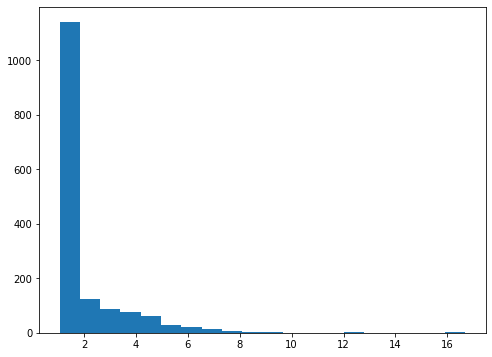

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(weights, bins=20);

Now, the main model

In [ ]:
y = nhefs.wt82_71
X = nhefs[['constant', 'qsmk']]

Weighted least squares gives the right coefficients, but the standard error is off.

In [ ]:
wls = sm.WLS(y, X, weights=weights) 
res = wls.fit()
res.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

GEE gives the right coefficients and better standard errors

In [ ]:
gee = sm.GEE(
    nhefs.wt82_71,
    nhefs[['constant', 'qsmk']],
    groups=nhefs.seqn,
    weights=weights
)
res = gee.fit()
res.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

In [ ]:
est = res.params.qsmk
conf_ints = res.conf_int(alpha=0.05, cols=None)
lo, hi = conf_ints[0]['qsmk'], conf_ints[1]['qsmk']

print('           estimate   95% C.I.')
print('theta_1     {:>6.2f}   ({:>0.1f}, {:>0.1f})'.format(est, lo, hi))

           estimate   95% C.I.
theta_1       3.44   (2.4, 4.5)


Here's a simple check that there is no association between `sex` and `qsmk`.

In [ ]:
pd.crosstab(nhefs.sex, nhefs.qsmk, weights, aggfunc='sum')

qsmk           0           1
sex                         
0     763.607760  763.623497
1     801.748892  797.200691

(This matches the R output, but the Stata output is different.)

In [ ]:
subset_indices = (nhefs.race == 0) & (nhefs.sex == 1)
subset = nhefs.loc[subset_indices]

Now a check for positivity

In [ ]:
crosstab = pd.crosstab(subset.age, subset.qsmk).sort_index()

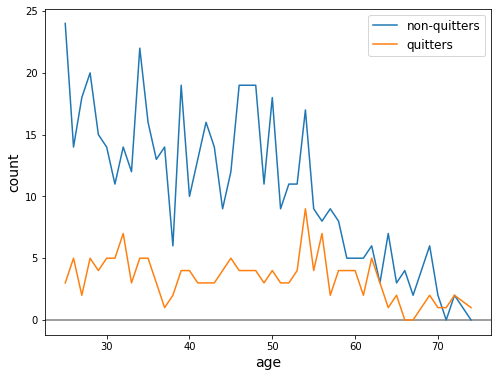

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.axhline(0, c='gray')
ax.plot(crosstab.index, crosstab[0], label='non-quitters')
ax.plot(crosstab.index, crosstab[1], label='quitters')
ax.set_xlabel('age', fontsize=14)
ax.set_ylabel('count', fontsize=14)
ax.legend(fontsize=12);

We see that there are actually a few ages with zero counts

In [ ]:
crosstab.iloc[-10:]

qsmk  0  1
age       
63    3  3
64    7  1
65    3  2
66    4  0
67    2  0
69    6  2
70    2  1
71    0  1
72    2  2
74    0  1

For a discussion on ages with zero counts, see Fine Point 12.2, pg 155.

## 12.3 Stabilized IP weights

Create the stabilized IP weights $SW^A = f(A) \, / \, f(A|L)$

"The effect estimate obtained in the pseudo-population created by weights $0.5 \, / \, f(A|L)$
is equal to that obtained in the pseudo-population created by weights $1 \, / \, f(A|L)$."

In [ ]:
gee = sm.GEE(
    nhefs.wt82_71,
    nhefs[['constant', 'qsmk']],
    groups=nhefs.seqn,
    weights=(0.5 * weights)
)
res = gee.fit()
res.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

"Second, we need to estimate Pr[A=1] for the numerator of the weights. We can obtain a nonparametric estimate by the ratio 403/1566 or, equivalently, by fitting a saturated logistic model for Pr[A=1] with an intercept and no covariates." pg 154

In [ ]:
qsmk = (nhefs.qsmk == 1)

In [ ]:
# option 1
qsmk_mean = qsmk.mean()
qsmk_mean

0.25734355044699875

In [ ]:
# option 2
lgt = sm.Logit(qsmk, nhefs.constant)
res = lgt.fit()
res.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.570260
         Iterations 5


<class 'statsmodels.iolib.table.SimpleTable'>

In [ ]:
lgt_pred = res.predict()

Check for equivalence

In [ ]:
equivalent = np.all(np.isclose(lgt_pred, qsmk_mean))
print('equivalent: {}'.format(equivalent))

equivalent: True


### Program 12.3

Create stabilized IP weights. Shortcut: modify the IP weights already calculated.

In [ ]:
s_weights = np.zeros(nhefs.shape[0])
s_weights[qsmk] = qsmk.mean() * weights[qsmk]    # `qsmk` was defined a few cells ago
s_weights[~qsmk] = (1 - qsmk).mean() * weights[~qsmk]

In [ ]:
print('Stabilized weights')
print(' min   mean    max')
print('------------------')
print('{:>04.2f}   {:>04.2f}   {:>04.2f}'.format(
    s_weights.min(),
    s_weights.mean(),
    s_weights.max()
))

Stabilized weights
 min   mean    max
------------------
0.33   1.00   4.30


Refit the model from the last section, using the new weights

In [ ]:
gee = sm.GEE(
    nhefs.wt82_71,
    nhefs[['constant', 'qsmk']],
    groups=nhefs.seqn,
    weights=s_weights
)
res = gee.fit()
res.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

In [ ]:
est = res.params.qsmk
conf_ints = res.conf_int(alpha=0.05, cols=None)
lo, hi = conf_ints[0]['qsmk'], conf_ints[1]['qsmk']

print('           estimate   95% C.I.')
print('theta_1     {:>6.2f}   ({:>0.1f}, {:>0.1f})'.format(est, lo, hi))

           estimate   95% C.I.
theta_1       3.44   (2.4, 4.5)


The estimate is the same as in the previous section

We can check again for no association between sex and qsmk in the the pseudo-population

In [ ]:
pd.crosstab(nhefs.sex, nhefs.qsmk, s_weights, aggfunc='sum')

qsmk           0           1
sex                         
0     567.098228  196.513582
1     595.423986  205.154456

## 12.4 Marginal structural models

Models for the marginal mean of a counterfactual outcome are referred to as marginal structural mean models. 反事实结果的边际均值模型称为边际结构均值模型。

模型的各种变体，从离散的连续。

Marginal structural mean models within a pseudo-population:

$$E[Y^a] = \beta_0 + \beta_1 a$$ 
$$\Rightarrow E[Y^a] = \beta_0 + \beta_1 a + \beta_2 a^2$$ 


marginal structural logistic model

$$logit Pr[Y^a = 1] = \beta_0 + \beta_1 a$$ 

### Program 12.4

Subset the data to subjects that smoked 25 or fewer cigarettes per day at baseline. In this case, we can either obtain the subset from the original dataset, or we can obtain it from the reduced dataset that we've been using. I'll get it from the reduced subset, since it already contains dummy features we'll need.

In [ ]:
# from original dataset

intensity25 = nhefs_all.loc[
    (nhefs_all.smokeintensity <= 25) & ~nhefs_all.wt82.isnull()
]
intensity25.shape

(1162, 64)

In [ ]:
# from reduced dataset

intensity25 = nhefs.loc[nhefs.smokeintensity <= 25]
intensity25.shape

(1162, 83)

Create the stabilized IP weights $SW^A = f(A) \, / \, f(A|L)$

"we assumed that the density f(A|L) was normal (Gaussian) with mean $\mu = E[A|L]$ and variance $\sigma^2$.  We then used a linear regression model to estimate the mean $E[A|L]$ and variance of residuals $\sigma^2$ for all combinations of values of L." pg 156


In [ ]:
A = intensity25.smkintensity82_71
X = intensity25[[
    'constant', 'sex', 'race', 'edu_2', 'edu_3', 'edu_4', 'edu_5', 
    'exercise_1', 'exercise_2', 'active_1', 'active_2',
    'age', 'age^2', 'wt71', 'wt71^2',
    'smokeintensity', 'smokeintensity^2', 'smokeyrs', 'smokeyrs^2'
]]

In [ ]:
ols = sm.OLS(A, X)
res = ols.fit()

In [ ]:
A_pred = res.predict(X)   # i.e., E[A|L]

The denominator is the distribution, $N(\mu, \sigma)$, evaluated at each point of $y = A$.

In [ ]:
fAL = scipy.stats.norm.pdf(
    A,                        # A
    A_pred,                   # mu = E[A|L]
    np.sqrt(res.mse_resid)    # sigma
)

"We also assumed that the density f(A) in the numerator was normal."

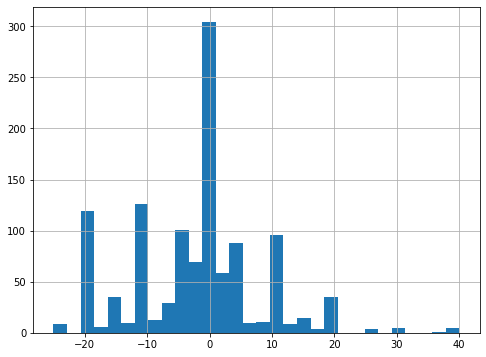

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

A.hist(bins=30, ax=ax);

In [ ]:
A.mean(), A.std()

(-2.057659208261618, 10.467830908151853)

In [ ]:
fA = scipy.stats.norm.pdf(A, A.mean(), A.std())

Then the stabilized IP weights are

In [ ]:
sw = fA / fAL

In [ ]:
print('Stabilized weights')
print(' min   mean    max')
print('------------------')
print('{:>04.2f}   {:>04.2f}   {:>04.2f}'.format(
    sw.min(),
    sw.mean(),
    sw.max()
))

Stabilized weights
 min   mean    max
------------------
0.19   1.00   5.10


Now fit the marginal structural model

In [ ]:
y = intensity25.wt82_71
X = pd.DataFrame(OrderedDict((
    ('constant', np.ones(y.shape[0])),
    ('A', A),
    ('A^2', A**2)
)))

model = sm.GEE(
    y,
    X,
    groups=intensity25.seqn,
    weights=sw
)
res = model.fit()

In [ ]:
res.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

To get the estimate and confidence interval for "no change", you can read off the values in the `constant` row above (because `A` and `A^2` will be zero).

Getting Statmodels to calculate the estimate and confidence interval for when smoking increases by 20 cigarettes / day will take a couple extra steps. In Chapter 11, the regression result had a `get_prediction` method. The GEE result doesn't (yet?) have that _method_, so we'll use the hidden `get_prediction` _function_.

In [ ]:
from statsmodels.regression._prediction import get_prediction

In [ ]:
pred_inputs = [
    [1, 0, 0],       # no change in smoking intensity
    [1, 20, 20**2],  # plus 20 cigarettes / day
]
pred = get_prediction(res, exog=pred_inputs)
summary = pred.summary_frame().round(1)
summary[["mean", "mean_ci_lower", "mean_ci_upper"]]

mean  mean_ci_lower  mean_ci_upper
0   2.0            1.4            2.6
1   0.9           -1.7            3.5

We can relabel the rows and columns to make this table a little nicer

In [ ]:
summary = summary[["mean", "mean_ci_lower", "mean_ci_upper"]]
summary.index = ["no change", "+20 per day"]
summary.columns = ["estimate", "CI lower", "CI upper"]
summary

estimate  CI lower  CI upper
no change         2.0       1.4       2.6
+20 per day       0.9      -1.7       3.5

Note: since the `get_predictions` function wasn't attached to the GEE regression result, it might not work correctly with other versions of the GEE model.

### Program 12.5

"if interested in the causal effect of quitting smoking A (1: yes, 0: no) on the risk of death D (1: yes, 0: no) by 1982, one could consider a _marginal structural logistic model_"

In [ ]:
model = sm.GEE(
    nhefs.death,
    nhefs[['constant', 'qsmk']],
    groups=nhefs.seqn,
    weights=s_weights,
    family=sm.families.Binomial()
)
res = model.fit()
res.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

Odd ratio is $\exp(\hat{\theta}_1)$

In [ ]:
est = np.exp(res.params.qsmk)
conf_ints = res.conf_int(alpha=0.05, cols=None)
lo = np.exp(conf_ints[0]['qsmk'])
hi = np.exp(conf_ints[1]['qsmk'])

print('           estimate   95% C.I.')
print('odds ratio  {:>6.2f}   ({:>0.1f}, {:>0.1f})'.format(est, lo, hi))

           estimate   95% C.I.
odds ratio    1.03   (0.8, 1.4)


## 12.5 Effect modification and marginal structural models

Marginal structural models do not include covariates when the target parameter is the average causal effect in the population. However, one may include covariates–which may be non-confounders–in a marginal structural model to assess effect modification.

在第一部分中，我们讨论了 effect modification and confounding 是两个在逻辑上截然不同的概念。 但是，许多学生很难理解这种区别，因为经常使用相同的统计方法（分层（第4章）或回归（第15章）for confounder adjustment and detection of effect modification. 因此，使用边际结构模型来讲授这些概念可能会有一些优势， because then methods for confounder adjustment (IP weighting) are distinct from methods for detection of effect modification (adding treatment-covariate product terms to a marginal structural model).


### Program 12.6

Create the numerator of the IP weights. Reuse the basic `weights` for the denominator.

In [ ]:
numer = logit_ip_f(nhefs.qsmk, nhefs[['constant', 'sex']])

Optimization terminated successfully.
         Current function value: 0.567819
         Iterations 5


In [ ]:
sw_AV = numer * weights

In [ ]:
print('Stabilized weights')
print(' min   mean    max')
print('------------------')
print('{:>04.2f}   {:>04.2f}   {:>04.2f}'.format(
    sw_AV.min(),
    sw_AV.mean(),
    sw_AV.max()
))

Stabilized weights
 min   mean    max
------------------
0.29   1.00   3.80


In [ ]:
nhefs.shape

(1566, 83)

In [ ]:
nhefs['qsmk_and_female'] = nhefs.qsmk * nhefs.sex

model = sm.WLS(
    nhefs.wt82_71,
    nhefs[['constant', 'qsmk', 'sex', 'qsmk_and_female']],
    weights=sw_AV
)
res = model.fit(cov_type='cluster', cov_kwds={'groups': nhefs.seqn})
res.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

## 12.6 Censoring and missing data


### Program 12.7

We're going back to the original dataset

In [ ]:
nhefs_all.shape

(1629, 64)

We'll add features that were added to the reduced dataset that we've been using

Add constant feature

In [ ]:
nhefs_all['constant'] = 1

Add dummy features

In [ ]:
edu_dummies = pd.get_dummies(nhefs_all.education, prefix='edu')
exercise_dummies = pd.get_dummies(nhefs_all.exercise, prefix='exercise')
active_dummies = pd.get_dummies(nhefs_all.active, prefix='active')

nhefs_all = pd.concat(
    [nhefs_all, edu_dummies, exercise_dummies, active_dummies],
    axis=1
)

Add squared features

In [ ]:
for col in ['age', 'wt71', 'smokeintensity', 'smokeyrs']:
    nhefs_all['{}^2'.format(col)] = nhefs_all[col] * nhefs_all[col]

We'll also add a feature to track censored individuals

In [ ]:
nhefs_all['censored'] = nhefs_all.wt82.isnull().astype('int')

Create the IP weights for treatment

In [ ]:
X_ip = nhefs_all[[
    'constant', 'sex', 'race', 'edu_2', 'edu_3', 'edu_4', 'edu_5', 
    'exercise_1', 'exercise_2', 'active_1', 'active_2',
    'age', 'age^2', 'wt71', 'wt71^2',
    'smokeintensity', 'smokeintensity^2', 'smokeyrs', 'smokeyrs^2'
]]

In [ ]:
ip_denom = logit_ip_f(nhefs_all.qsmk, X_ip)

Optimization terminated successfully.
         Current function value: 0.542264
         Iterations 6


In [ ]:
ip_numer = logit_ip_f(nhefs_all.qsmk, nhefs_all.constant)

Optimization terminated successfully.
         Current function value: 0.575901
         Iterations 5


In [ ]:
sw_A = ip_numer / ip_denom

In [ ]:
print('Stabilized weights')
print(' min   mean    max')
print('------------------')
print('{:>04.2f}   {:>04.2f}   {:>04.2f}'.format(
    sw_A.min(),
    sw_A.mean(),
    sw_A.max()
))

Stabilized weights
 min   mean    max
------------------
0.33   1.00   4.21


Now the IP weights for censoring

In [ ]:
# same as previous, but with 'qsmk' added

X_ip = nhefs_all[[
    'constant', 'sex', 'race', 'edu_2', 'edu_3', 'edu_4', 'edu_5', 
    'exercise_1', 'exercise_2', 'active_1', 'active_2',
    'age', 'age^2', 'wt71', 'wt71^2',
    'smokeintensity', 'smokeintensity^2', 'smokeyrs', 'smokeyrs^2',
    'qsmk'
]]

In [ ]:
ip_denom = logit_ip_f(nhefs_all.censored, X_ip)

Optimization terminated successfully.
         Current function value: 0.142836
         Iterations 8


In [ ]:
ip_numer = logit_ip_f(
    nhefs_all.censored,
    nhefs_all[['constant', 'qsmk']]
)

Optimization terminated successfully.
         Current function value: 0.161989
         Iterations 7


In [ ]:
sw_C = ip_numer / ip_denom
sw_C[nhefs_all.censored == 1] = 1

In [ ]:
print('Stabilized weights')
print(' min   mean    max')
print('------------------')
print('{:>04.2f}   {:>04.2f}   {:>04.2f}'.format(
    sw_C.min(),
    sw_C.mean(),
    sw_C.max()
))

Stabilized weights
 min   mean    max
------------------
0.94   1.00   1.72


Now create the combined IP weights

In [ ]:
sw_AC = sw_A * sw_C

In [ ]:
print('Stabilized weights')
print(' min   mean    max')
print('------------------')
print('{:>04.2f}   {:>04.2f}   {:>04.2f}'.format(
    sw_AC.min(),
    sw_AC.mean(),
    sw_AC.max()
))

Stabilized weights
 min   mean    max
------------------
0.35   1.00   4.09


Now model weight gain using the combined IP weights

In [ ]:
wls = sm.WLS(
    nhefs.wt82_71,
    nhefs[['constant', 'qsmk']],
    weights=sw_AC[nhefs_all.censored == 0]
) 
res = wls.fit(cov_type='cluster', cov_kwds={'groups': nhefs.seqn})

In [ ]:
res.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

## End to End

### 一个类组织本章代码

In [8]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from collections import OrderedDict
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats
import matplotlib.pyplot as plt

In [9]:
class IPW(object):
    def __init__(self):
        self.help = "This is a demonstration for IP Weighting!"
        self.data = self.get_data()
        self.ipw_cols = None
    
    def get_data(self):
        nhefs_all = pd.read_excel('NHEFS.xls')
        restriction_cols = ['sex', 'age', 'race', 'wt82', 'ht', 
                            'school', 'alcoholpy', 'smokeintensity']
        missing = nhefs_all[restriction_cols].isnull().any(axis=1)
        nhefs = nhefs_all.loc[~missing]
        nhefs['constant'] = 1
        nhefs['university'] = (nhefs.education == 5).astype('int')
        nhefs['inactive'] = (nhefs.active == 2).astype('int')
        nhefs['no_exercise'] = (nhefs.exercise == 2).astype('int')  
        for col in ['age', 'wt71', 'smokeintensity', 'smokeyrs']:
            nhefs['{}^2'.format(col)] = nhefs[col] * nhefs[col]        
        edu_dummies = pd.get_dummies(nhefs.education, prefix='edu')
        exercise_dummies = pd.get_dummies(nhefs.exercise, prefix='exercise')
        active_dummies = pd.get_dummies(nhefs.active, prefix='active')

        nhefs = pd.concat(
            [nhefs, edu_dummies, exercise_dummies, active_dummies],
            axis=1
        )
        return nhefs

    def _logit_ip_f(self, y, X):
        model = sm.Logit(y, X)
        res = model.fit()
        weights = np.zeros(X.shape[0])
        weights[y == 1] =   res.predict(X.loc[y == 1])
        weights[y == 0] = (1 - res.predict(X.loc[y == 0]))
        return weights
    
    def treatment_probs(self, cols=None):
        if cols is None:
            cols = ['constant', 'sex', 'race', 'age', 'age^2', 'edu_2', 'edu_3', 'edu_4', 'edu_5',
                    'smokeintensity', 'smokeintensity^2', 'smokeyrs', 'smokeyrs^2', 
                    'exercise_1', 'exercise_2', 'active_1', 'active_2', 'wt71', 'wt71^2']
        self.ipw_cols = cols
        print('Confounders for IP Weight is:\n', cols)
        print()
        
        X_ip = self.data[cols] 
        
        return self._logit_ip_f(self.data.qsmk, X_ip)    
    
    def ipw(self):
        nhefs = self.data
        denoms = self.treatment_probs(self.ipw_cols)
        weights = 1 / denoms
        assert(weights.shape[0] == self.data.shape[0])
        print('Min and Max of weights:', weights.min(), weights.max())
        
        gee = sm.GEE(
            nhefs.wt82_71,
            nhefs[['constant', 'qsmk']],
            groups=nhefs.seqn,
            weights=weights
        )
        res = gee.fit()
        return res.summary().tables[1]
    
    def stabled_ipw(self):
        nhefs = self.data
        qsmk = (nhefs.qsmk == 1)
        denoms = self.treatment_probs(self.ipw_cols)
        weights = 1 / denoms
        s_weights = np.zeros(nhefs.shape[0])
        s_weights[qsmk] = qsmk.mean() * weights[qsmk]    # `qsmk` was defined a few cells ago
        s_weights[~qsmk] = (1 - qsmk).mean() * weights[~qsmk]
        print(qsmk.mean())
        gee = sm.GEE(
            nhefs.wt82_71,
            nhefs[['constant', 'qsmk']],
            groups=nhefs.seqn,
            weights=s_weights
        )
        res = gee.fit()
        return res.summary().tables[1]

    def marginal_structural_models(self):
        nhefs = self.data
        numer = self._logit_ip_f(nhefs.qsmk, nhefs[['constant', 'sex']])
        weights = 1 / self.treatment_probs()
        sw_AV = numer * weights
        nhefs['qsmk_and_female'] = nhefs.qsmk * nhefs.sex
        model = sm.WLS(
            nhefs.wt82_71,
            nhefs[['constant', 'qsmk', 'sex', 'qsmk_and_female']],
            weights=sw_AV
        )
        res = model.fit(cov_type='cluster', cov_kwds={'groups': nhefs.seqn})
        print('Marignal Structural Models 的有关变量:\n', ['constant', 'qsmk', 'sex', 'qsmk_and_female'] )
        return res.summary().tables[1]

g = IPW()
# g.data.shape
# g.ipw_cols = ['constant', 'sex', 'race', 'age']
# g.ipw()
# g.stabled_ipw()
g.marginal_structural_models()

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
Optimization terminated successfully.
         Current function value: 0.567819
         Iterations 5
Confounders for IP Weight is:
 ['constant', 'sex', 'race', 'age', 'age^2', 'edu_2', 'edu_3', 'edu_4', 'edu_5', 'smokeintensity', 'smokeintensity^2', 'smokeyrs', 'smokeyrs^2', 'exercise_1', 'exercise_2', 'active_1', 'active_2', 'wt71', 'wt71^2']

Optimization terminated successfully.
         Current function value: 0.535408
         Iterations 6
Marignal Structural Models 的有关变量:
 ['constant', 'qsmk', 'sex', 'qsmk_and_female']


<class 'statsmodels.iolib.table.SimpleTable'>

### Mini Ch12

这里我们重新组织和整理本章的内容，a mini version of this chapter。

本书第二部分围绕因果问题“戒烟对体重增加的平均因果效应是什么？”进行组织。在本章中，我们描述如何使用IP加权从观测数据中估计这种效应。尽管在第二章中介绍了IP加权，但我们仅将其描述为非参数方法。We now describe the use of models together with IP weighting，在额外的假设下，这些模型将使我们能够处理高维问题 with many covariates and nondichotomous treatments.

Table of Contents

- IPW via modeling
- Stablized IPW
- Marginal structural models
- Effect modification and marginal structural models
- Censoring and missing data

In [32]:
g = IPW()
nhefs = g.data
g.data[['qsmk', 'wt82_71']].head()

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


qsmk    wt82_71
0     0 -10.093960
1     0   2.604970
2     0   9.414486
3     0   4.990117
4     0   4.989251

### 因果效应估计

四种的方法估计因果效应：

- 直接计算均值的差异: 4.525079 - 1.98449 $\approx$ 2.52
- 一元线性模型 2.54 - 1.98 = 0.56
- IPW 方法 3.44 - 1.78 = 1.66
- Stablized IPW 3.44 - 1.78

In [30]:
nhefs.groupby('qsmk')["wt82_71"].mean()
# nhefs.groupby('qsmk')["wt82_71"].agg(["mean", "median"])

qsmk
0    1.984498
1    4.525079
Name: wt82_71, dtype: float64

In [10]:
# 用线性回顾估计因果效应的
ols = sm.OLS(nhefs.wt82_71, nhefs[['constant', 'qsmk']])
res = ols.fit()
res.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

In [33]:
# IP Weight 方法
g.ipw()

Confounders for IP Weight is:
 ['constant', 'sex', 'race', 'age', 'age^2', 'edu_2', 'edu_3', 'edu_4', 'edu_5', 'smokeintensity', 'smokeintensity^2', 'smokeyrs', 'smokeyrs^2', 'exercise_1', 'exercise_2', 'active_1', 'active_2', 'wt71', 'wt71^2']

Optimization terminated successfully.
         Current function value: 0.535408
         Iterations 6
Min and Max of weights: 1.0537416280320455 16.700094350727504


<class 'statsmodels.iolib.table.SimpleTable'>

In [34]:
# Stablized IPW
g.stabled_ipw()

Confounders for IP Weight is:
 ['constant', 'sex', 'race', 'age', 'age^2', 'edu_2', 'edu_3', 'edu_4', 'edu_5', 'smokeintensity', 'smokeintensity^2', 'smokeyrs', 'smokeyrs^2', 'exercise_1', 'exercise_2', 'active_1', 'active_2', 'wt71', 'wt71^2']

Optimization terminated successfully.
         Current function value: 0.535408
         Iterations 6
0.25734355044699875


<class 'statsmodels.iolib.table.SimpleTable'>

In [35]:
# marginal_structural_models
g.marginal_structural_models()

Optimization terminated successfully.
         Current function value: 0.567819
         Iterations 5
Confounders for IP Weight is:
 ['constant', 'sex', 'race', 'age', 'age^2', 'edu_2', 'edu_3', 'edu_4', 'edu_5', 'smokeintensity', 'smokeintensity^2', 'smokeyrs', 'smokeyrs^2', 'exercise_1', 'exercise_2', 'active_1', 'active_2', 'wt71', 'wt71^2']

Optimization terminated successfully.
         Current function value: 0.535408
         Iterations 6
Marignal Structural Models 的有关变量:
 ['constant', 'qsmk', 'sex', 'qsmk_and_female']


<class 'statsmodels.iolib.table.SimpleTable'>